 1번
- 데이터 경로 /kaggle/input/adp-p6/problem1.csv 

### 데이터 설명
- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.     
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.     
- Description: Product (item) name. Nominal.    
- Quantity: The quantities of each product (item) per transaction. Numeric.     
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.   
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.    
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.     
- Country: Country name. Nominal, the name of the country where each customer resides.     


### 데이터 출처
- https://archive.ics.uci.edu/ml/index.php

In [ ]:
import pandas as pd

In [ ]:
df =pd.read_csv('/kaggle/input/adp-p6/problem1.csv')
df.head()

## 1-1. 결측치를 확인하고, 결측치 제거할 것

In [ ]:
df.info()
df.isnull().sum()

In [ ]:
df.dropna(inplace = True)
df.info()

## 1-2. 이상치 제거하는 방법을 설명하고, 이상치 제거하고 난 결과를 통계적으로 나타낼 것

### 이상치 확인 및 정제
#### 이상치의 의미
* 관측값의 형식과 다른 형식의 값으로 표시된 결측치
  * ERROR값
* 관측값의 형식과 같은 형식의 값으로 표시된 결측치
  * 100점 만점인 시험 컬럼에서 999점
* 자료 수집의 오류로 발생한 이상치
  * 거실 온도 컬럼에서 2345도
* 다른 관측치들과는 현저히 차이나는 실제 관측치
  * 일자별 게임 시간에서 20시간(나머지는 1~5시간)

#### 이상치 확인
이상치를 확인하는 방법은 데이터에 따라 다양하지만, 주로 boxplot에서 닫힌구간 [Q1-1.5*IQR, Q3+1.5*IQR] 밖에 있는 값을 이상치로 정의한다.
물론, 정규화를 이용하여 이상치를 정의할 수도 있다.

In [1]:
# boxplot을 통해 이상치 확인하기
import matplotlib.pyplot as plt
import seaborn as sns

x = df[['Quantity', 'UnitPrice']]

x_melt = pd.melt(x, var_name='col', value_name='value')

plt.figure(figsize=(20, 10))
sns.boxplot(x='col', y='value', data = x_melt)
plt.xticks(range(2), x.columns)
plt.show()

NameError: name 'df' is not defined

In [ ]:
# 이상치를 가져오는 함수 정의 후 이상치의 위치와 값 확인해보기
import numpy as np
def outliers_iqr(dt, col):
    quantile_1, quantile_3 = np.percentile(dt[col], [25, 75])
    iqr = quantile_3-quantile_1
    lower_whis = quantile_1-1.5*iqr
    upper_whis = quantile_3+1.5*iqr
    outliers = dt[(dt[col]>upper_whis)|(dt[col]<lower_whis)]
    return outliers[[col]]

outliers_Quantity = outliers_iqr(df, 'Quantity')
print(outliers_Quantity)
outliers_UnitPrice = outliers_iqr(df, 'UnitPrice')
print(outliers_UnitPrice)

print('Quantity 변수의 이상치 비율 : ', round(100*len(outliers_Quantity)/len(df), 2), '%')
print('UnitPrice 변수의 이상치 비율 : ', round(100*len(outliers_UnitPrice)/len(df), 2), '%')

In [ ]:
# 이상치 제거
# 데이터의 수가 매우 많고 이상치가 존재하는 행이 전체 데이터에 비해 많지 않은 경우 이상치가 존재하는 행 전체를 삭제할 수 있다.

drop_outliers = df.drop(index=outliers_Quantity.index)
drop_outliers = df.drop(index=outliers_UnitPrice.index)

# 이상치를 삭제하기 전과 후의 데이터 shape
print('Original : ', df.shape)
print('Drop outliers : ', drop_outliers.shape)

## 1-3 전처리한 데이터로 Kmeans, DBSCAN 등 방법으로 군집을 생성할 것

* K-means의 장점
    * 일반적인 군집화에서 가장 많이 활용되는 알고리즘이다.
    * 알고리즘이 쉽고 간결하다.
* K-means의 단점
    * 거리 기반 알고리즘으로 속성의 개수가 매우 많을 경우 군집화 정확도가 떨어진다.
        * 이를 위해 PCA로 차원을 축소하고 적용해야할 필요가 있을 수도 있다.
    * 반복을 수행하는데, 반복 횟수가 많을 경우 수행 시간이 느려진다.
    * 몇 개의 군집을 선택해야 할지가 하이퍼파라미터로 정해져 있어 가이드하기 어렵다.

In [ ]:
# Kmeans 수행 전 전처리
import warnings
warnings.filterwarnings('ignore')

# 수치형 변수 스케일링 해주기(feat. Standard)
# CustomerID, Description은 필요 없어 보이므로 삭제
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df1 = df[['Quantity', 'UnitPrice']]
df1 = pd.DataFrame(scaler.fit_transform(df1), columns = df1.columns)

# object형 변수 라벨인코딩 해주기
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df2 = df[['InvoiceNo', 'StockCode', 'InvoiceDate', 'Country']]
df2['InvoiceNo'] = encoder.fit_transform(df2['InvoiceNo'])
df2['StockCode'] = encoder.fit_transform(df2['StockCode'])
df2['InvoiceDate'] = encoder.fit_transform(df2['InvoiceDate'])
df2['Country'] = encoder.fit_transform(df2['Country'])

df3 = pd.merge(df1, df2, left_index=True,right_index=True, how='inner')

# Kmeans 수행
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# n_clusters = 5로 군집 수행
kmeans = KMeans(n_clusters = 3, random_state=731).fit(df1)

df_clustered = df1
df_clustered['cluster'] = kmeans.labels_

df_clustered

In [ ]:
# 군집이 잘 되었는지, 주성분 분석을 이용하여 설명변수를 2개로 만들어 2차원으로 차원을 축소하고 평면 위에 산점도로 나타내보기
from sklearn.decomposition import PCA

df4 = df3[df3.columns.difference(['Country', 'cluster'])]

pca = PCA(n_components = 2)
pca_transformed = pd.DataFrame(pca.fit_transform(df4), columns = ['p1', 'p2'])

pca_transformed['cluster'] = df_clustered['cluster'].astype('int')
pca_transformed

In [ ]:
sns.scatterplot(data = pca_transformed, x='p1', y='p2', hue='cluster')
plt.show()

스케일링 해도 문제네..

# 2번

## 2-1. 위에서 생성한 군집들의 특성을 분석할 것

## 2-2. 각 군집 별 대표 추천 상품을 도출할 것

## 2-3. CustomerID가 12413인 고객을 대상으로 상품을 추천할 것

# 3번
### 철강제품의 불량률을 조사하고자 한다. 이 때, 불량률의 90%, 추정오차한계가 5% 이내가 되기 위하여 적절한 표본의 크기 중 최소값은 얼마인가?

90%와 관련된 Z값은 1.645이고, $\hat{p}=0.9,\ \hat{q}=0.1,$ $d(허용오차)=0.05$이므로

In [ ]:
import math
z=1.645
p_hat=0.9
q_hat=1-p_hat
d=0.05

n=(z**2 * p_hat * q_hat)/(d**2)
print('조건을 만족시키는 표본의 크기 n 중 최솟값은 ',math.ceil(n), '이다.')

# 4번
### 다음은 1월부터 9월까지의 은의 가격이다
![image](https://github.com/Datamanim/datarepo/blob/main/adp/26/problem2.png?raw=true)

## 4-1 은의 가격 및 이동평균값 3이 설정된 시계열 그래프를 그려라

In [1]:
# df 생성
import pandas as pd

df = pd.DataFrame({'month' : ['2023-1', '2023-2', '2023-3', '2023-4', '2023-5', '2023-6', '2023-7', '2023-8', '2023-9'],
                  'USD/oz' : [12.14, 42.6, 34.4, 35.29, 30.96, 57.12, 37.84, 42.49, 31.38]})

df

,month,USD/oz
0,2023-1,12.14
1,2023-2,42.60
2,2023-3,34.40
3,2023-4,35.29
4,2023-5,30.96
5,2023-6,57.12
6,2023-7,37.84
7,2023-8,42.49
8,2023-9,31.38


In [2]:
# dtype 변경
df['month'] = pd.to_datetime(df['month'], format = '%Y-%m')
df.set_index('month', inplace = True)
df

,USD/oz
month,
2023-01-01,12.14
2023-02-01,42.60
2023-03-01,34.40
2023-04-01,35.29
2023-05-01,30.96
2023-06-01,57.12
2023-07-01,37.84
2023-08-01,42.49
2023-09-01,31.38


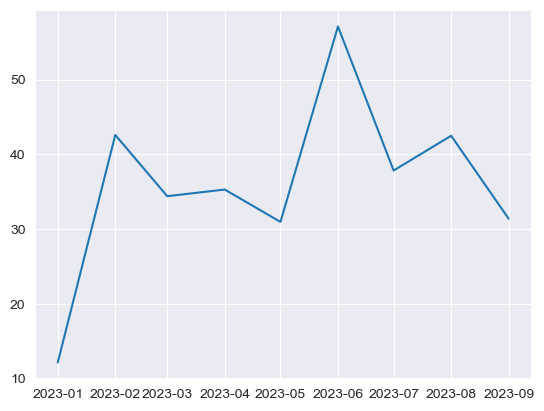

In [3]:
# 시계열 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(df.index, df['USD/oz'])
plt.show()

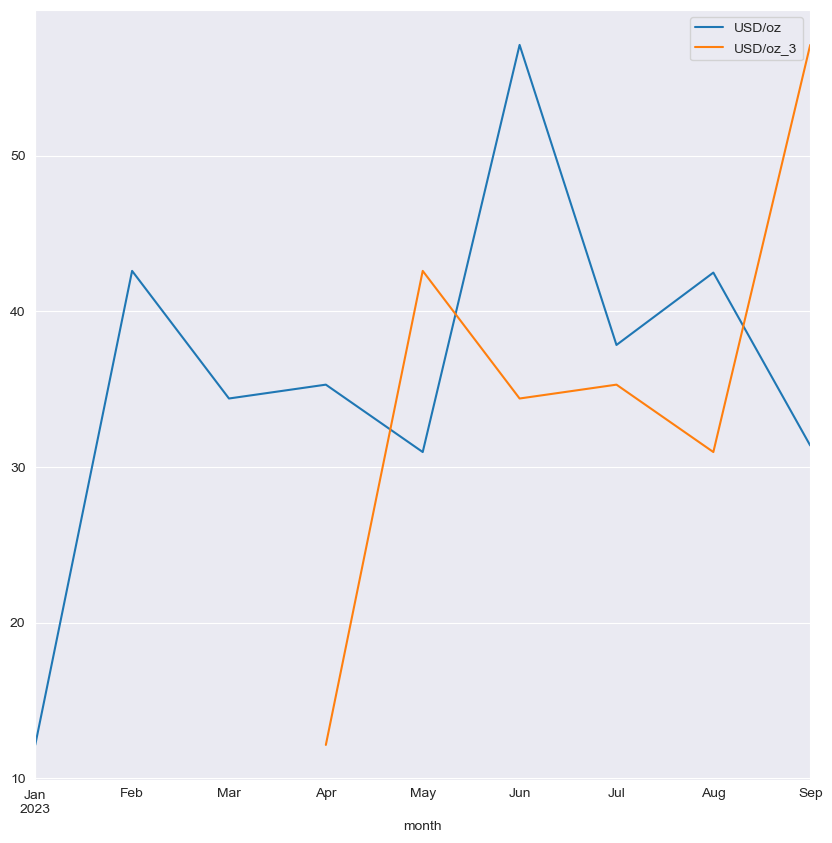

In [4]:
# 이동평균 3 적용한 것과 같이 나타내기
df['USD/oz_3'] = df['USD/oz'].shift(3)
df[['USD/oz', 'USD/oz_3']].plot(figsize=(10, 10))
plt.show()

## 4-2 1월 대비 9월의 은의 가격은 몇 % 올랐는가? 소수점 두번째 자리에서 반올림

In [5]:
jan = df.loc['2023-01-01','USD/oz']
sep = df.loc['2023-09-01','USD/oz']
print('1월 대비 9월의 은의 가격은 ', round(((100*(sep-jan))/jan), 2), '% 올랐다.')

1월 대비 9월의 은의 가격은  158.48 % 올랐다.


# 5번 A,B,C 자치구별 W 의원에 대한 찬성, 반대 지지를 나타낸다.      
# 자치구별 지지율이 같은지에 대해서 검정하라



![image](https://github.com/Datamanim/datarepo/blob/main/adp/26/problem3.png?raw=true)

## 5-1 연구가설과 귀무가설을 설정하라

* 귀무가설 : 자치구별 지지율은 같다.
* 대립가설 : 자치구별 지지율은 다르다.

## 5-2 검정통계량 구하고 결론을 내라

In [6]:
# 지지율에 대한  df 생성
import pandas as pd

df = pd.DataFrame({'A' : [176/(176+124)],
                   'B' : [193/(193+107)],
                   'C' : [159/(159+141)]})
print(df)
n=300

          A         B     C
0  0.586667  0.643333  0.53


In [9]:
import numpy as np

p_a = df.iloc[0, 0]
p_b = df.iloc[0, 1]
p_c = df.iloc[0, 2]

m_ab = (369)/(600)
m_bc = (352)/(600)
m_ca = (335)/(600)

# A=B?
# 귀무가설 : A=B이다.
# 대립가설 : A!=B이다.
Z_ba = (p_b-p_a)/(np.sqrt((m_ab * (1-m_ab))/n))

# A=C?
# 귀무가설 : A=C이다.
# 대립가설 : A!=C이다.
Z_ca = (p_c-p_a)/(np.sqrt((m_ca * (1-m_ca))/n))

# B=C?
# 귀무가설 : B=C이다.
# 대립가설 : B!=C이다.
Z_bc = (p_c-p_b)/(np.sqrt((m_bc * (1-m_bc))/n))
print(Z_ba, Z_ca, Z_bc)

2.0170672190388546 -1.9764881000906767 -3.9863219216896035


유의수준 5%하에서 Z값은 1.96이므로 기각역은 +-1.96이 된다.
이때, Z_ba = 2.01... 이므로 검정통계량은 기각역 안에 위치하게 된다.
즉, 귀무가설이 기각되고, 대립가설을 채택한다.
따라서 A, B 두 자치구의 지지율은 같지 않다.

같은 방법으로, 유의수준 5%하에서 Z값은 1.96이므로 기각역은 +-1.96이 된다.
이때, Z_ca = -1.97... 이므로 검정통계량은 기각역 안에 위치하게 된다.
즉, 귀무가설이 기각되고, 대립가설을 채택한다. 따라서 A, C 두 자치구의 지지율은 같지 않다.

유의수준 5%하에서 Z값은 1.96이므로 기각역은 +-1.96이 된다.
이때, Z_bc = -3.98... 이므로 검정통계량은 기각역 안에 위치하게 된다.
즉, 귀무가설이 기각되고, 대립가설을 채택한다. 따라서 B, C 두 자치구의 지지율은 같지 않다.

#### 따라서, 세 자치구 A, B, C의 지지율은 서로 같지 않음을 알 수 있다.

# 6번 
## A초등학교 남학생 16명과 여학생 9명의 혈압을 측정한 problem4.csv파일을 가지고 남녀학생의 평균 혈압에 차이가 없는지 분석하라. 단, 남학생과 여학생의 혈압 데이터는 정규분포를 따르며 등분산임을 가정한다.

## 6-1. 연구가설과 귀무가설 설정하라

* 귀무가설 : 남녀 학생의 평균 혈압에는 차이가 없다.
* 대립가설 : 남녀 학생의 평균 혈압에는 차이가 있다.

## 6-2. 통계량을 구하고, 연구가설 채택여부를 기술하라.

In [2]:
# df 만들기
import pandas as pd

df = pd.read_csv('/kaggle/input/adp-p6/problem4.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/adp-p6/problem4.csv'

In [3]:
df.info()

NameError: name 'df' is not defined

이때, 정규성과 등분산성이 가정되었으므로 따로 확인하지 않고, 독립표본 t검정을 실시한다.

In [4]:
# 독립표본 t-test 진행
import scipy.stats as stats

male = df[df['gender'] == 'male']['pressure']
female = df[df['gender'] == 'female']['pressure']

stats.ttest_ind(male, female, equal_var = True)

NameError: name 'df' is not defined

#### p-value가 0.123으로 유의수준인 0.05보다 크게 나타났다.
#### 따라서 귀무가설을 채택한다. 즉, 남녀 학생의 평균 혈압에는 차이가 없다고 할 수 있다.

## 6-3. 6-2에서 구한 검정 통계량 값을 바탕으로 신뢰구간을 구하라

In [1]:
import numpy as np

male_mean = male.mean()
female_mean = female.mean()
male_std = np.std(male)
female_std = np.std(female)
male_n = len(male)
female_n = len(female)
df_ttest = male_n+female_n

print(male_mean, female_mean, male_std, female_std, male_n, female_n, df_ttest)

s = np.sqrt(0.5 * (male_n**2+female_n**2))
SEM = np.sqrt((s**2)/male_n+(s**2)/female_n)

# 자유도가 25일 때, 이에 해당하는 양측을호의 꼬리 부분을 제외한 넓이가 0.95인 t-value는 2.06이다.
t_95 = 2.06

confidence_interval_left = male_mean-female_mean - t_95*SEM
confidence_interval_right = male_mean-female_mean + t_95*SEM

print('95%에 대한 신뢰 구간 : [', confidence_interval_left, ', ', confidence_interval_right, ']' )

NameError: name 'male' is not defined

즉, 95%의 확률로 위의 신뢰 구간 사이에 남녀 학생의 혈압 차이의 모평균이 들어온다고 할 수 있다.

# 7번 
## height(키), weight(몸무게), waist(허리둘레) 컬럼을 가진 problem7.csv파일을 가지고 다음을 분석하라.
A시의 20대 남성 411명을 임의로 추출하여 키, 몸무게, 허리둘레를 조사하여 기록한 데이터이다.      
이 데이터를 이용하여 20대 남성의 키와 허리둘레가 체중에 영향을 미치는지 알아보고자 한다

## 7-1 아래 조건을 참고하여 회귀계수(반올림하여 소수점 두자리)를 구하시오.
- 베이지안 회귀
- 시드넘버 1234로 지정
- 1000번의 burn-in 이후 10,000의 MCMC를 수행
- 회귀계수의 사전분포는 부적절한 균일분포(inproper uniform prior distribution), 오차항의 분산의 사전분포는 역감마 분포로 지정. 이때, 형상(Shape)모수와 척도(Scale)모수는 각각 0.005로 지정.

In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/input/adp-p6/problem7.csv')
df.head()

In [ ]:
import pymc3 as pm
import matplotlib.pyplot as plt

## 7-2 7-1에서 만든 모델을 바탕으로 키 180cm, 허리둘레 85cm인 남성의 몸무게를 추정하라